# Машинное обучение для текстов: Классификация комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. [Загрузите и подготовьте данные](#1)
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 8.7MB/s 
     |████████████████████████████████| 2.9MB 35.8MB/s 
     |████████████████████████████████| 890kB 52.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4ffd823cd8ee271f4ef5c39c7aa3f6651c519185098a16b3d36ed4413f8b1170
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


<a id="1"></a>
# 1. Подготовка

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
# for BERT
import torch
import torch.nn as nn
import transformers
import tensorflow as tf
from transformers import AutoModel, BertTokenizerFast
# specify GPU
device = torch.device("cuda")

In [ ]:
# from io import BytesIO
# import requests
# spreadsheet_id = '1TLd-iskswKVcWjdNfZtwoTjVIM4OH7w-'
# file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
# r = requests.get(file_name)
# df = pd.read_csv(BytesIO(r.content), sep=',')
# df


In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
# df = df.sample(n = 1000, random_state = 1)

In [ ]:
df

,text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
...,...,...
119965,FUCKASS ople like him... Thanks. I hate peopl...,1
149832,"I agree, as much as humanly possible, to avoid...",0
68147,REDIRECT Talk:Scooby-Doo! WrestleMania Mystery,0
39863,"""\n Not done: This is not supported by reliabl...",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
print('Количество дублирующихся строк:', df.duplicated().sum())

Количество дублирующихся строк: 0


In [ ]:
df.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

В нашем распоряжении данные, состоящие из признака (комментарии) и целевого признака (лейбл токсичности комментария). Данные без пропусков, без дубликатов. Имеются мусорные спец.символы. имеется дисбаланс в лейблах.

## Проведем стемминг и очистку текста от спец символов

Лемматизацию сделать не получилось, так как процесс зависал или проходил более 12 часов без результата.

In [ ]:
# def make_clear_text(text):
#     clear_text = " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())
#     return clear_text

# df['text_lemma'] = (df['text'].apply(make_clear_text)).str.lower()

In [ ]:
# %%time
# def make_lemmas(text):
#     # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
#     nlp = spacy.load('en', disable=['parser', 'ner'])
#     # Parse the sentence using the loaded 'en' model object `nlp`
#     doc = nlp(text)
#     # Extract the lemma for each token and join
#     lemma = " ".join([token.lemma_ for token in doc])
#     return lemma
#     #> 'the strip bat be hang on -PRON- foot for good'
# df['text_lemma'] = (df['text_lemma'].apply(make_lemmas))

# display(df)

Проведем стемминг с очисткой от специальных символов (при помощи SnowballStemmer и регулярного выражения)

In [ ]:
%%time
def make_clear_text(text):
    clear_text = " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())
    return clear_text

df['text_stem'] = (df['text'].apply(make_clear_text))

# def make_stem(text):
#     english_stemmer = SnowballStemmer('english')

#     stem_list = []
#     for word in text.split():
#         stem_list.append(english_stemmer.stem(word))
#     stem = " ".join(stem_list)
#     return stem  

# df['text_stem'] = df['text_stem'].apply(make_stem)

display(df)

,text,toxic,text_stem
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,YOU ARE A FAT GEEKY PRICK WHO HAS NOTHING TO D...
75819,Agent X2: Basically thanks - with a 'little' m...,0,Agent X Basically thanks with a little more Li...
53891,Why are my posts being deleted? \n\nI have tri...,0,Why are my posts being deleted I have tried to...
154159,"""\n\n Controlled Demolitions and Common Sense ...",0,Controlled Demolitions and Common Sense recomm...
13040,I do not understand your reply. //Blaxthos ( ...,0,I do not understand your reply Blaxthos t c
...,...,...,...
119965,FUCKASS ople like him... Thanks. I hate peopl...,1,FUCKASS ople like him Thanks I hate people lik...
149832,"I agree, as much as humanly possible, to avoid...",0,I agree as much as humanly possible to avoid m...
68147,REDIRECT Talk:Scooby-Doo! WrestleMania Mystery,0,REDIRECT Talk Scooby Doo WrestleMania Mystery
39863,"""\n Not done: This is not supported by reliabl...",0,Not done This is not supported by reliable sou...


CPU times: user 682 ms, sys: 783 µs, total: 682 ms
Wall time: 686 ms


Текст очистили от мусорных символов.

- Стемминг ухудшает качество модели, поэтому отключим его. 

Разделим исходный данные на тренировочную и тестовую выборки.

In [ ]:
train, test = train_test_split(df, test_size = 0.1, random_state = 1)

Создадам корпус слов, привядя к кодировки UTF-8 (признак) и целевой признак

In [ ]:
corpus_train = train['text_stem'].values.astype('U')
target_train = train['toxic']

Проведем кодирование (трансформирование) слов в цифровую матрицу.

Оценка важности слова определяется величиной TF-IDF (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Мы будем использовать словарь стоп-слов, чтобы неприемлимые комментарии отправлялись на модерацию.

In [ ]:
%%time
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf_train = count_tf_idf.fit_transform(corpus_train)

corpus_test = test['text_stem'].values.astype('U')
target_test = test['toxic']
tf_idf_test = count_tf_idf.transform(corpus_test)
tf_idf_test.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
CPU times: user 3.15 s, sys: 13.8 ms, total: 3.16 s
Wall time: 3.29 s


In [ ]:
print("Размер матрицы:", tf_idf_train.shape)

Размер матрицы: (143613, 158672)


# 2. Обучение

## LogisticRegression

Обучим модель LogisticRegression, присвоим сбалансированноть весов.

In [ ]:
%%time
model_LogisticRegression = LogisticRegression(class_weight = 'balanced',
                                              max_iter = 300,
                                              penalty = 'l2',
                                              # penalty = 'elasticnet', 
                                              C = 3.0,
                                              # solver = 'saga',
                                              # l1_ratio = 1,
                                              random_state = 1,
                                              n_jobs = -1)
model_LogisticRegression.fit(tf_idf_train, target_train)

CPU times: user 21.8 ms, sys: 189 ms, total: 211 ms
Wall time: 2.52 s


Сделаем предсказания и вычислим метрику качесва модели F1-score.

In [ ]:
pred_train = model_LogisticRegression.predict(tf_idf_train)
print('f1_score train:', f1_score(target_train, pred_train))
pred_test = model_LogisticRegression.predict(tf_idf_test)
print('f1_score test:', f1_score(target_test, pred_test))

f1_score train: 0.915271033594292
f1_score test: 0.7551202137132681


### Вывод

На логистической регресии мы получили качество F1-метрики:
**f1_score test: 0.765**
Это удовлетворяет условию задачи.

## RandomForestClassifier

Подберем гиперпараметры модели RandomForestClassifier при помощи интсрумента GridSearchCV

In [ ]:
# %%time
# clf = RandomForestClassifier()

# parameter_grid = {
#             'max_depth': [3, 10, 50],
#             'n_estimators': [100, 500, 1000]
            
#         }

# grid_searcher = GridSearchCV(clf, parameter_grid, verbose=10)
# grid_searcher.fit(tf_idf_train, target_train)
# clf_best = grid_searcher.best_estimator_
 
# print('Best params = ', clf_best.get_params())

При обучении модели будем использовать параметры:
 max_depth = 50, n_estimators=100, random_state = 1, class_weight='balanced'

In [ ]:
%%time
model_RandomForestClassifier = RandomForestClassifier(max_depth = 50, 
                                                      n_estimators=1000, 
                                                      random_state = 1, 
                                                      class_weight='balanced',
                                                      n_jobs = -1)
model_RandomForestClassifier.fit(tf_idf_train, target_train)

CPU times: user 13min 14s, sys: 1.18 s, total: 13min 15s
Wall time: 6min 43s


In [ ]:
pred_train = model_RandomForestClassifier.predict(tf_idf_train)
print('f1_score train:', f1_score(target_train, pred_train))

f1_score train: 0.5736238204903499


In [ ]:
pred_test = model_RandomForestClassifier.predict(tf_idf_test)
print('f1_score test:', f1_score(target_test, pred_test))

f1_score test: 0.488487750967029


### Вывод

На модели RandomForestClassifier мы получили качество F1-метрики:
**f1_score test: 0.488** - это хуже, модели логистической регрессии.

## CatBoostClassifier

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.2MB 97kB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
%%time
model_CatBoostClassifier = CatBoostClassifier(
                                              iterations = 1000,
                                              # n_estimators = 3000,
                                              # class_weights=[0.1, 5],
                                              auto_class_weights = 'Balanced',
                                            #  task_type= 'GPU',
                                             verbose=100)
model_CatBoostClassifier.fit(tf_idf_train, target_train)


Learning rate set to 0.085912
0:	learn: 0.6537812	total: 3.35s	remaining: 55m 45s
100:	learn: 0.3828162	total: 4m 48s	remaining: 42m 46s
200:	learn: 0.3276968	total: 9m 34s	remaining: 38m 3s
300:	learn: 0.2948485	total: 14m 19s	remaining: 33m 15s
400:	learn: 0.2712125	total: 19m 3s	remaining: 28m 28s
500:	learn: 0.2540586	total: 23m 48s	remaining: 23m 42s
600:	learn: 0.2392379	total: 28m 33s	remaining: 18m 57s
700:	learn: 0.2278687	total: 33m 17s	remaining: 14m 12s
800:	learn: 0.2176246	total: 38m 1s	remaining: 9m 26s
900:	learn: 0.2089369	total: 42m 45s	remaining: 4m 41s
999:	learn: 0.2011025	total: 47m 24s	remaining: 0us
CPU times: user 1h 27min 54s, sys: 28.3 s, total: 1h 28min 23s
Wall time: 48min 17s


In [ ]:
pred_train = model_CatBoostClassifier.predict(tf_idf_train)
print('f1_score train:', f1_score(target_train, pred_train))

pred_test = model_CatBoostClassifier.predict(tf_idf_test)
print('f1_score test:', f1_score(target_test, pred_test))

f1_score train: 0.8204861004689367
f1_score test: 0.7660979636763897


### Вывод

На модели СatBoostClassifier мы получили качество F1-метрики: **f1_score test: 0.766**. Обучение модели происходит довольно медленно.

## BERT

Возьмем готовую модель BERT (от англ. Bidirectional Encoder Representations from Transformers, «двунаправленная нейронная сеть-кодировщик») — нейронная сеть для создания модели языка. 

Из нашего датасета возьмем часть данных, так как мощность аппартных устройств (объём памяти GPU) не позволяет нам произвести обучение модели на полных данных.

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
df = df.sample(n = 50000, random_state = 1)

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['toxic'], 
                                                                    random_state=1, 
                                                                    test_size=0.2, 
                                                                    stratify=df['toxic'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=1, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


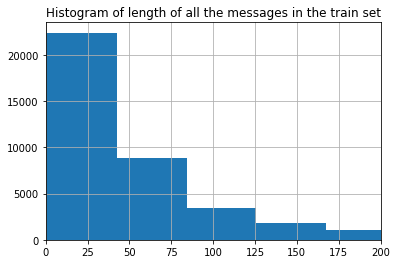

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
plt.title('Histogram of length of all the messages in the train set')
plt.xlim(0, 200)
plt.grid(True)
plt.show()

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.55774004 4.82975127]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 17

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
%%time
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 17


AttributeError: ignored

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
print('f1_score test:', f1_score(test_y, preds))

### Вывод
Качество модели BERT **f1_score test: 0.543**

# 3. Выводы

Мы провели обучение моделей, которые ищут токсичные комментарии и отправляют их на модерацию.
В результате обучения моделей мы получили следующие показатели метрики оценки качества F1 -score на тестовых данных:

- LogisticRegression F1 - score: 0.76
- RandomForestClassifier F1 - score: 0.48
- СatBoostClassifier F1 - score: 0.76
- BERT F1 - score: 0.54

Для сайта мы предложим модель LogisticRegression, она показала высокое качество и быструю скорость обучения.